# Simulation and Performance Evaluation - Homework 3

### University of Trento - A.Y. 2019 / 2020

Lotito Quintino Francesco - 215032

Zanella Davide - 211463

---

**Important:** we delivered two files, a .ipynb file (jupyter notebook) and a .html file (export of the notebook), if the .ipynb file is run we expect the datasets to be in the same directory of this notebook in order to be read as input.

## Exercise 1

### Problem statement

Consider the following “weird” probability density function:

$ f(x) = \frac{\mid sinc(x)\mid}{A} = \frac{1}{A} \mid \frac{sin(\pi x)}{\pi x} \mid $

where $-6 \leq x \leq 6$, and $A = 1.8988$ is a normalization factor such that $\int_{-6}^{6} f(t) dt = 1$
 is in fact a PDF. (Recall that sinc(x) is not defined for $x = 0$, but can be continuously extended to take the value $sinc(0) = 1$.)
 
1. Employ rejection sampling to draw a large number of samples from the above PDF.
2. Plot the resulting empirical PDF (e.g., through a histogram) and compare it against $f(x)$.


### Solution

The first thing to do is define the function described in the problem statement:
$f(x) = \frac{1}{A} \mid \frac{sin(\pi x)}{\pi x} \mid $



In [206]:
from math import sin, pi
import random as rnd

In [207]:
def f(x):
    A = 1.8988
    if x == 0:
        return 1/A
    return 1/A * abs(sin(pi * x) / (pi * x))

The following function implements the rejection sampling method for an arbitrary number of times, sampling from the previous funcion $f(x)$.

The bounds of the rectangle where we are sampling from are $[-6, 6]$ for the $x$ axis and $[0, 0.55]$ for the $y$ one. The first interval is defined by the problem statement, while the second one is obtained from the sine boundaries $[-1, 1]$ limited by the absolute value and divided by A. So more or less $[0, 0.55]$.

In [208]:
def rejection_sampling(n):
    points = []
    for i in range(n):
        U1 = rnd.uniform(-6, 6)
        U2 = rnd.uniform(0, 0.55)
    
        if U2 < f(U1):
            points.append(U1)
    return points

Using the $f(x)$ function previously defined, we can now plot the function in the interval where it is defined and see how it behaves.

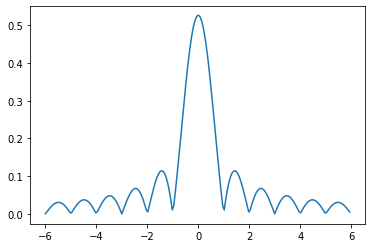

In [209]:
from matplotlib import pyplot as plt

steps = 200
x = [ -6 + (12/steps)*i for i in range(steps)]
y = [f(i) for i in x]

plt.plot(x, y)
plt.ylim(top=0.55)
plt.show()

The following is a useful function that will be used nextly to plot easily our empirical Probability distribution functions.

In the histogram function of `matplotlib` the flag density is setted to True in order to normaliza the data and obtain an integral of the area euqal to $1$ and respect the problem specification: $\int_{-6}^{6} f(t) dt = 1$.

In [210]:
from matplotlib import pyplot as plt

def plot_point(x):
    plt.hist(x, bins=200, density=True)

    plt.ylim(top=0.55)

    plt.show()

With $10^5$ as number of sampling, we obtain a worse plot with respect to the previous one. All the peaks are less defined and smoothed with respect to the theoretical function.

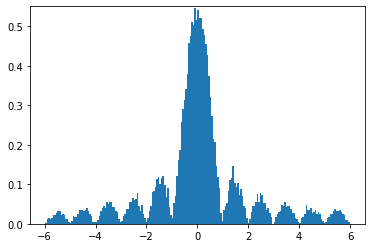

In [211]:
points = rejection_sampling(100000)
plot_point(points)

Increasing the number of samples to $10^8$, rises sensibly the computation time but gives some enhancements.

The obtained plot is more smoothed compared to the previous empirical one, and the peaks are better defined than before. To obtain a plot exactly equal to the theoretical one, the number of samples should increase, up to infinite. This is impossible, because of the time needed for the computation.

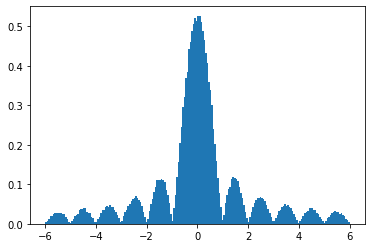

In [212]:
points = rejection_sampling(1000000)
plot_point(points)

## Exercise 2

## Exercise 3

### Problem statement

Consider the network scenario of Fig. 2. A source S wants to transmit a packet to destination D. A multihop
network separates S from D. Specifically, there are r stages, each of which contains N relays. The source is
connected to all nodes of stage 1. Each node of stage 1 is connected to all nodes of stage 2; each node of stage 2
is connected to all nodes of stage 3, and so on. Finally, all nodes of stage r are connected to D. The probability
of error over every link in the whole network is equal to p.

S employs a flooding policy to send its packet through the network. This means that every node that receives
the packet correctly will re-forward it exactly once. Note that this has implications for the probability that a
given relay receives a packet correctly.
For example, at relay stage 1, the probability that any node will fail to receive the packet from S is $p$. However,
say that $k$ nodes at stage $i$ receive the packet correctly: because of the flooding policy, all k nodes will retransmit
the packet. Therefore, the probability that a node at stage $i + 1$ fails to receive the packet is not $p$, but rather
$p^k$ (i.e., the probability that no transmissions from any of the $k$ relays at stage $i$ are received by the node at
stage $i + 1$).

1. Use Monte-Carlo simulation to estimate the probability that a packet transmitted by the source S fails
to reach the destination D. Consider two different cases: $r = 2$, $N = 2$, and $r = 5$, $N = 10$. For each
Monte-Carlo trial, simulate the transmission of the packet by S, the correct or incorrect reception by the relays at stage 1, the retransmission of the packet towards the next stages, and so forth until the packet reaches D or is lost in the process.
(Hint: remember that the probability to fail the reception of a packet is $p^k$ , where $k$ is the number of
nodes that hold a copy of the packet at the previous stage.)
2. Repeat the above process for different values of the link error probability p. Plot the probability of error
at D against p for the two cases {r = 2, N = 2}, and {r = 5, N = 10}. Plot also the confidence intervals
for each simulation point.
3. Compare your results against the theoretical error probability curve provided in the file theory_ex3.csv
(column 1: values of p; column 2: probability of error at D for {r = 2, N = 2}; column 3: probability of
error at D for {r = 5, N = 10}).
4. Draw conclusions on the behavior of the network for the chosen values of r and N .
5. Plot the average number of successful nodes at each stage, and the corresponding confidence intervals.
What can you say about the relationship between the number of successful nodes and the probability of
error at D?

### Solution

Firstly, we define a function to compute a Monte-Carlo simulation, receiving as parameters $r$, $N$, $p$ and $n\_iter$, that is the number of the iteration done in the simulation.

Basically, for every iteration it's computed the probability of the links connecting every stage, then for every node in the current stage, it's randomly decided if it receives correctly the packet or not concerning the computed probability. In every iteration, we store the number of nodes that receive correctly the packet for every stage. We count even if after every iteration the $D$ node receives correctly at least a packet.

The result of the function is two lists. The first one contains a series of $0$ and $1$ that states if the packet is received correctly by the $D$ node. The second list contains for every stage the number of nodes that received correctly the packet.

In [213]:
import random as rnd

def MC_simulation(r, n, p, n_iter):
    n_received = 0
    tot_succ_nodes = []
    for _ in range(n_iter):
        n_succ = 1
        for ns in range(r):
            prob_loss = p**n_succ
            n_succ = 0
            for node in range(n):
                v = rnd.random()
                if v > prob_loss:
                    n_succ += 1
            tot_succ_nodes.append(n_succ)

        if n_succ > 0:
            n_received += 1
    return [0] * n_received + [1] * (n_iter-n_received), tot_succ_nodes

Now, we define a simple function to compute the mean of a list.

In [214]:
def compute_mean(values):
    tot = 0
    for i in values:
        tot += i
    return tot / len(values)

The previous mean function can be now used to compute the probability that a packet transmitted by the source $S$ fails to reach the destination $D$ from the Monte-Carlo simulation with parameters:
$r = 2$, $N = 2$, $p = 0.2$ and $n\_iter = 1000$.

In [215]:
compute_mean(MC_simulation(2, 2, 0.2, 1000)[0])

0.063

Now, we compute the probability as before but changing the parameters as follows:
$r = 5$, $N = 10$, $p = 0.2$ and $n\_iter = 1000$.

In [216]:
compute_mean(MC_simulation(5, 10, 0.2, 1000)[0])

0.0

The two following functions are used to compute the standard deviation and the mean interval of some data.

In [217]:
def compute_std_dev(values):
    mean = compute_mean(values)
    tot = 0
    for i in values:
        tot += (i - mean) ** 2
    return math.sqrt(tot / len(values))

In [218]:
import math

def mean_interval(data, gamma):
    eta = None
    if gamma == 0.95:
        eta = 1.960
    elif gamma == 0.99:
        eta = 2.576
    else:
        # in these excercises we are only interested in 95% and 99% confidence
        pass
    mean = compute_mean(data)
    std_dev = compute_std_dev(data)
    incr = eta * std_dev / math.sqrt(len(data))
    return mean - incr, mean + incr

Now, we define a function to do a Monte-Carlo simulation, using the previousy defined function, for $100$ different link error probabilities. For each simulation's result it computes the 95% confidence interval and plot all the results. If the specific parameters are passed, the function plot even the theoretical function that describes the probability of having errors at node $D$ with respect to the error link probability.

In [219]:
from matplotlib import pyplot as plt

def plot_MC_simulation(r, n, theory=None, theory_col=1):
    steps = 100
    probs = [(1/steps)*i for i in range(steps)]

    results = []
    lower = []
    upper = []

    for p in probs:
        vals = MC_simulation(r, n, p, 1000)[0]
        results.append(compute_mean(vals))
        low, up = mean_interval(vals, 0.95)
        lower.append(low)
        upper.append(up)


    plt.plot(probs, results, label='Simulated error probability')
    plt.plot(probs, lower, c='r', label='Bounds C.I. 95%')
    plt.plot(probs, upper, c='r')
    plt.title('Monte carlo simulation - r: {} N: {}'.format(r, n))
    plt.xlabel('Link prob of error')
    plt.ylabel('Prob of error at D')
    
    if theory != None:
        plt.plot(theory[0], theory[theory_col], c='g', label='Theoretical error probability')
    
    plt.legend()
    plt.show()

Executing the previous function with $r = 2$ and $N = 2$, gives the result below.

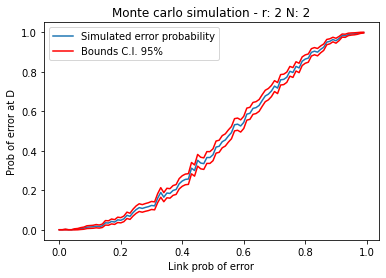

In [220]:
plot_MC_simulation(2, 2)

Now, we are asked to do the same for $r = 5$ and $N = 10$.

The difference between the two plots is evident. The previous one is pretty linear: at the increasing of the link error probability, it increases more or less in the same way even the probability of an error at node $D$.
While, in the following plot, until $0.6$ for the link error probability, the probability of an error at $D$ is very close to zero. Only after $0.6$ the error probability at $D$ increases fastly.

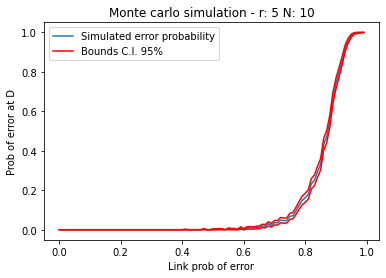

In [221]:
plot_MC_simulation(5, 10)

Now, we need to load the dataset of the theoretical distribution.

In [222]:
def load():
    file = open("theory_ex3.csv", "r")
    values = [[float(i) for i in x.split(',') ] for x in file.readlines()]
    new_val = [
        [i[0] for i in values],
        [i[1] for i in values],
        [i[2] for i in values]
    ]
    return new_val

In [223]:
theory = load()

Using the previous function we can plot our Monte-Carlo simulation and on the same graph the theoretical distribution loaded from the csv. Both for the two configuration parameters of $r$ and $N$.

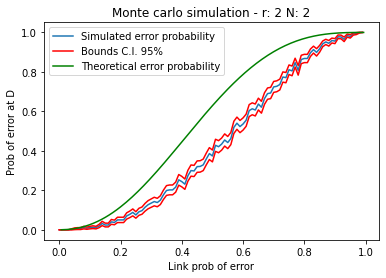

In [224]:
plot_MC_simulation(2, 2, theory, 1)

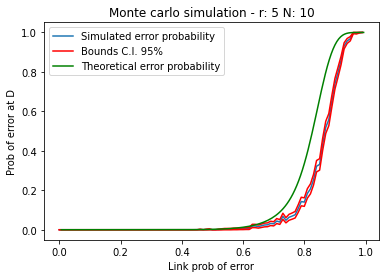

In [225]:
plot_MC_simulation(5, 10, theory, 2)

In both the previous plots, the theoretical error probabilities behave better than our simulated ones, especially for the one with $r = 2$ and $N = 2$.

The following consideration is intuitively correct, but now our plots confirm it: with more nodes per network stage we can obtain a more robust system. The number of stages doesn't seem to impact negatively the resulting probability of error at $D$. Anyway, we can suppose that with an $r$ value too higher than $N$, the final curve would be similar to a logarithmic one, reaching fastly the value 1.

The following is a modificated version of the previous one that plots the average number of nodes per stage of each Monte-Carlo simulation.

In [226]:
from matplotlib import pyplot as plt

def plot_avg_succ_nodes(r, n):
    steps = 100
    probs = [(1/steps)*i for i in range(steps)]
    
    succ_nodes = []
    lower = []
    upper = []
    values = []

    for p in probs:
        vals, nodes = MC_simulation(r, n, p, 1000)
        low, up = mean_interval(nodes, 0.95)
        lower.append(low)
        upper.append(up)
        
        succ_nodes.append(compute_mean(nodes))
        values.append(compute_mean(vals))


    plt.plot(values, succ_nodes, label='Avg number of succ nodes per stage')
    plt.plot(values, lower, c='r', label='Bounds C.I. 95%')
    plt.plot(values, upper, c='r')
    plt.title('Monte carlo simulation - r: {} N: {}'.format(r, n))
    plt.xlabel('Prob of error at D')
    plt.ylabel('Avg number of succ nodes per stage')
    
    
    plt.legend()
    plt.show()

Using the previous function we can now plot the average nuber of nodes per stage that successfully received the packet in each simulation.

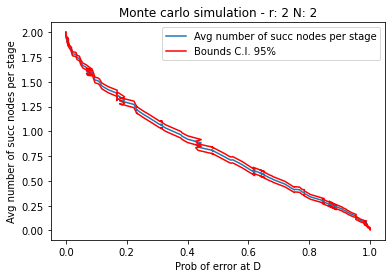

In [227]:
plot_avg_succ_nodes(2, 2)

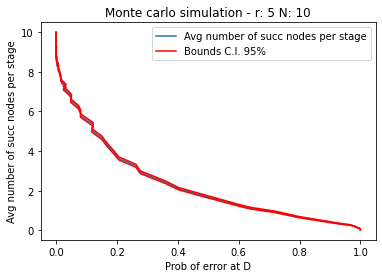

In [228]:
plot_avg_succ_nodes(5, 10)

The plots above clearly show the relationship between the average number of successful nodes per stage and the probability of error at $D$. With the decreasing of the number of successful nodes, it increases the probability of error at the destination $D$. With a high number of nodes per stage, we have a robust system and the curve reaches the 1 value on the x-axis slowly.